In [45]:
import os
import shutil
import glob
import pandas as pd
import numpy as np
from tqdm import tqdm
import datetime
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.lines import Line2D


In [46]:
evals_root = os.path.join('..', '..','evaluations', 'mAP')
evals_root_summary_stats = os.path.join('..', '..','evaluations', 'mAP_summary_stats')
if not os.path.exists(evals_root_summary_stats):
    os.makedirs(evals_root_summary_stats)
date_txt_now = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
evals_root_summary_stats = os.path.join(evals_root_summary_stats, date_txt_now)
if not os.path.exists(evals_root_summary_stats):
    os.makedirs(evals_root_summary_stats)

path_evals = glob.glob(os.path.join(evals_root, '*', '*epoch_mAP_data.pkl'))
path_evals

['..\\..\\evaluations\\mAP\\mAP_2024-05-28-11-08-24\\50epoch_mAP_data.pkl',
 '..\\..\\evaluations\\mAP\\mAP_2024-05-28-15-48-11\\150epoch_mAP_data.pkl',
 '..\\..\\evaluations\\mAP\\mAP_2024-05-30-09-53-30\\5epoch_mAP_data.pkl',
 '..\\..\\evaluations\\mAP\\mAP_2024-05-30-09-55-23\\15epoch_mAP_data.pkl']

In [47]:
dfs = []
pbar = tqdm(path_evals)
for path_eval in path_evals:
    df = pd.read_pickle(path_eval)
    print(df.shape)
    dfs.append(df)
    pbar.set_description(f'Loaded {path_eval}')
pbar.close()
df = pd.concat(dfs)
df.head()

Loaded ..\..\evaluations\mAP\mAP_2024-05-28-11-08-24\50epoch_mAP_data.pkl:   0%|          | 0/4 [00:04<?, ?it/s]

(60, 13)


Loaded ..\..\evaluations\mAP\mAP_2024-05-28-15-48-11\150epoch_mAP_data.pkl:   0%|          | 0/4 [00:11<?, ?it/s]

(18, 13)


Loaded ..\..\evaluations\mAP\mAP_2024-05-30-09-53-30\5epoch_mAP_data.pkl:   0%|          | 0/4 [00:28<?, ?it/s]  

(347, 13)


Loaded ..\..\evaluations\mAP\mAP_2024-05-30-09-55-23\15epoch_mAP_data.pkl:   0%|          | 0/4 [00:39<?, ?it/s]

(72, 13)


,path_model,path_dataset,mAP_score,embedding,path_settings_file,margin,batch_size,num_epochs,embedding_dim,n_layers,unfreeze_layers_epoch,unfreeze_all_epoch,n_unfreeze_layers
0,..\..\models\reid\Pycnopodia_helianthoides_ful...,..\..\data\Pycnopodia_helianthoides_full_event...,"{1: 0.9368998628257887, 5: 0.9636488340192044,...",i...,..\..\models\reid\Pycnopodia_helianthoides_ful...,0.1,8.0,50.0,256.0,3.0,1.0,51.0,128.0
1,..\..\models\reid\Pycnopodia_helianthoides_ful...,..\..\data\Pycnopodia_helianthoides_full_event...,"{1: 0.9320987654320988, 5: 0.9622770919067215,...",i...,..\..\models\reid\Pycnopodia_helianthoides_ful...,0.1,8.0,50.0,256.0,3.0,51.0,1.0,128.0
2,..\..\models\reid\Pycnopodia_helianthoides_ful...,..\..\data\Pycnopodia_helianthoides_full_event...,"{1: 0.9272976680384087, 5: 0.9602194787379973,...",i...,..\..\models\reid\Pycnopodia_helianthoides_ful...,0.3,8.0,50.0,256.0,3.0,1.0,51.0,128.0
3,..\..\models\reid\Pycnopodia_helianthoides_ful...,..\..\data\Pycnopodia_helianthoides_full_event...,"{1: 0.9293552812071331, 5: 0.9595336076817559,...",i...,..\..\models\reid\Pycnopodia_helianthoides_ful...,0.3,8.0,50.0,256.0,3.0,51.0,1.0,128.0
4,..\..\models\reid\Pycnopodia_helianthoides_ful...,..\..\data\Pycnopodia_helianthoides_full_event...,"{1: 0.9272976680384087, 5: 0.9588477366255144,...",i...,..\..\models\reid\Pycnopodia_helianthoides_ful...,0.5,8.0,50.0,256.0,3.0,1.0,51.0,128.0


In [48]:
df.shape

(497, 13)

In [49]:
def get_number_of_head_layers(file_path):
    with open(file_path, 'r') as file:
        for line in file:
            if "Optimizer" in line:
                key, value = line.split(':')
                return value.strip()

df['optimizer'] = [get_number_of_head_layers(os.path.join(os.path.dirname(path_model), 'logs', 'settings.txt')) for path_model in df['path_model'].tolist()]
df = df[df['optimizer'] == 'sgd']
del df['optimizer']
df.shape

(401, 13)

In [50]:
## delete rows with repeats of the same model
df = df.drop_duplicates(subset=['path_model'])
df.shape

(401, 13)

In [51]:
def convert_mAP_dict_into_arr (mAP_dict):

  x = []
  y = []
  for key, item in mAP_dict.items():
    x.append(key)
    y.append(item)
  x = np.array(x)
  y = np.array(y)

  return x,y

In [52]:
epoch_settings = sorted(list(df['num_epochs'].unique()))
margin_settings = sorted(list(df['margin'].unique()))
unfreeze_layers_epoch_setting = sorted(list(df['unfreeze_layers_epoch'].unique()))
unfreeze_all_epoch_setting = sorted(list(df['unfreeze_all_epoch'].unique()))
batchsize_settings = sorted(list(df['batch_size'].unique()))
embeddingdim_settings = sorted(list(df['embedding_dim'].unique()))
layer_settings = sorted(list(df['n_layers'].unique()))
datasets = sorted(list(df['path_dataset'].unique()))
src_datasets_key = {} ## we want to average results across each src dataset
for dataset in datasets:
  src_dataset = dataset.split('full_')[0].split('\\data\\')[1][:-1].replace('-re-id', '').replace('_', ' ').replace('Other species sea-star', 'ANAU')
  src_dataset = src_dataset.replace('Pycnopodia ', 'P.')
  src_datasets_key[dataset] = src_dataset
df['source_dataset'] = [src_datasets_key[key] for key in df['path_dataset'].tolist()]
source_datasets = sorted(list(df['source_dataset'].unique()))
source_datasets

['ANAU', 'P.helianthoides', 'Reduced P.helianthoides', 'Unmasked ANAU']

In [53]:

def convert_unfreeze_settings(unfreeze_all, unfreeze_layers, num_epochs):

    """
    we want to combine these codes into a single code that is more readable

    These are possible combinations of unfreezing settings

    Unfreeze all: 51.0, Unfreeze layers: 1.0, num epochs: 50.0
        becomes: '128L@epoch1'
    Unfreeze all: 1.0, Unfreeze layers: 51.0, num epochs: 50.0
        becomes: 'all@epoch1'
    Unfreeze all: 50.0, Unfreeze layers: 20.0, num epochs: 150.0
        becomes: '128L@epoch20, all@epoch50'
    Unfreeze all: 20.0, Unfreeze layers: 151.0, num epochs: 150.0
        becomes: 'all@epoch20'
    Unfreeze all: 50.0, Unfreeze layers: 30.0, num epochs: 150.0
        becomes: '128L@epoch30, all@epoch50'
    Unfreeze all: 30.0, Unfreeze layers: 151.0, num epochs: 150.0
        becomes: 'all@epoch30'
    Unfreeze all: 151.0, Unfreeze layers: 30.0, num epochs: 150.0
        becomes: '128L@epoch30'
    Unfreeze all: 25.0, Unfreeze layers: 15.0, num epochs: 5.0
        becomes: 'No unfreezing'
    Unfreeze all: 25.0, Unfreeze layers: 15.0, num epochs: 15.0
        becomes: 'No unfreezing'
    Unfreeze all: 50.0, Unfreeze layers: 15.0, num epochs: 15.0
        becomes: 'No unfreezing'
    """

    actions = []

    # Add unfreeze actions to the list if within epoch range
    if unfreeze_layers < num_epochs:
        actions.append((unfreeze_layers, f'128L@epoch{int(unfreeze_layers)}'))

    if unfreeze_all < num_epochs:
        actions.append((unfreeze_all, f'all@epoch{int(unfreeze_all)}'))

    # Sort actions by the epoch value
    actions.sort(key=lambda x: x[0])

    if not actions:
        return 'No unfreezing'

    # Combine the actions into a single string, separating by comma if both are present
    result = ', '.join(action[1] for action in actions)

    return result

unfreezing_settings = []

for i, row in df.iterrows():
    unfreeze_all = row['unfreeze_all_epoch']
    unfreeze_layers = row['unfreeze_layers_epoch']
    num_epochs = row['num_epochs']

    settings = convert_unfreeze_settings(unfreeze_all, unfreeze_layers, num_epochs)

    unfreezing_settings.append(settings)

unq_unfreezing_settings = sorted(list(set(unfreezing_settings)))

df['unfreezing_settings'] = unfreezing_settings

unq_unfreezing_settings


['128L@epoch1',
 '128L@epoch20, all@epoch50',
 '128L@epoch30',
 '128L@epoch30, all@epoch50',
 'No unfreezing',
 'all@epoch1',
 'all@epoch20',
 'all@epoch30']

In [54]:
df.head()

,path_model,path_dataset,mAP_score,embedding,path_settings_file,margin,batch_size,num_epochs,embedding_dim,n_layers,unfreeze_layers_epoch,unfreeze_all_epoch,n_unfreeze_layers,source_dataset,unfreezing_settings
0,..\..\models\reid\Pycnopodia_helianthoides_ful...,..\..\data\Pycnopodia_helianthoides_full_event...,"{1: 0.9368998628257887, 5: 0.9636488340192044,...",i...,..\..\models\reid\Pycnopodia_helianthoides_ful...,0.1,8.0,50.0,256.0,3.0,1.0,51.0,128.0,P.helianthoides,128L@epoch1
1,..\..\models\reid\Pycnopodia_helianthoides_ful...,..\..\data\Pycnopodia_helianthoides_full_event...,"{1: 0.9320987654320988, 5: 0.9622770919067215,...",i...,..\..\models\reid\Pycnopodia_helianthoides_ful...,0.1,8.0,50.0,256.0,3.0,51.0,1.0,128.0,P.helianthoides,all@epoch1
2,..\..\models\reid\Pycnopodia_helianthoides_ful...,..\..\data\Pycnopodia_helianthoides_full_event...,"{1: 0.9272976680384087, 5: 0.9602194787379973,...",i...,..\..\models\reid\Pycnopodia_helianthoides_ful...,0.3,8.0,50.0,256.0,3.0,1.0,51.0,128.0,P.helianthoides,128L@epoch1
3,..\..\models\reid\Pycnopodia_helianthoides_ful...,..\..\data\Pycnopodia_helianthoides_full_event...,"{1: 0.9293552812071331, 5: 0.9595336076817559,...",i...,..\..\models\reid\Pycnopodia_helianthoides_ful...,0.3,8.0,50.0,256.0,3.0,51.0,1.0,128.0,P.helianthoides,all@epoch1
4,..\..\models\reid\Pycnopodia_helianthoides_ful...,..\..\data\Pycnopodia_helianthoides_full_event...,"{1: 0.9272976680384087, 5: 0.9588477366255144,...",i...,..\..\models\reid\Pycnopodia_helianthoides_ful...,0.5,8.0,50.0,256.0,3.0,1.0,51.0,128.0,P.helianthoides,128L@epoch1


In [55]:
best_model_by_src_dataset = []
for src_dataset in source_datasets:
    tmp = df[df['source_dataset'] == src_dataset]
    mAP_dicts = []
    for i, row in tmp.iterrows():
        mAP_dict = row['mAP_score']
        mAP_dicts.append(mAP_dict)
    mAPs = []
    for mAP_dict in mAP_dicts:
        x, y = convert_mAP_dict_into_arr(mAP_dict)
        mAPs.append(y[0])
    path_model = tmp.iloc[np.argmax(mAPs)]['path_model']
    path_dataset = tmp.iloc[np.argmax(mAPs)]['path_dataset']
    print(path_model, np.max(mAPs))
    best_model_dir = os.path.join(evals_root_summary_stats, src_dataset)
    if not os.path.exists(best_model_dir):
        os.makedirs(best_model_dir)

    ## copy the model to the best model directory
    path_best = os.path.join(best_model_dir, os.path.basename(path_dataset) +'__'+os.path.basename(path_model))
    shutil.copy(path_model, path_best)

    best_model_by_src_dataset.append(tmp[tmp['path_model'] == path_model])
best_model_by_src_dataset = pd.concat(best_model_by_src_dataset)
best_model_by_src_dataset

..\..\models\reid\Other_species_sea-star-re-id-full_event-unaware_training-split_2024-05-03-18-28__2024-05-12-03-36-43__0__densenet121__PT-True\best_densenet121__PT-True.pth 0.9311163895486936
..\..\models\reid\Pycnopodia_helianthoides_full_event-unaware_training-split_2024-05-03-18-41__2024-05-13-04-10-58__0__densenet121__PT-True\best_densenet121__PT-True.pth 0.9429553264604811
..\..\models\reid\Reduced_Pycnopodia_helianthoides_full_event-unaware_training-split_2024-05-03-20-02__2024-05-20-08-01-32__0__densenet121__PT-True\best_densenet121__PT-True.pth 0.9435736677115988
..\..\models\reid\Unmasked_Other_species_sea-star-re-id-full_event-unaware_training-split_2024-05-05-15-33__2024-05-07-11-18-00__0__densenet121__PT-True\best_densenet121__PT-True.pth 0.8933649289099526


,path_model,path_dataset,mAP_score,embedding,path_settings_file,margin,batch_size,num_epochs,embedding_dim,n_layers,unfreeze_layers_epoch,unfreeze_all_epoch,n_unfreeze_layers,source_dataset,unfreezing_settings
8,..\..\models\reid\Other_species_sea-star-re-id...,..\..\data\Other_species_sea-star-re-id-full_e...,"{1: 0.9311163895486936, 5: 0.9904988123515439,...",i...,..\..\models\reid\Other_species_sea-star-re-id...,0.3,8.0,150.0,256.0,3.0,30.0,151.0,128.0,ANAU,128L@epoch30
12,..\..\models\reid\Pycnopodia_helianthoides_ful...,..\..\data\Pycnopodia_helianthoides_full_event...,"{1: 0.9429553264604811, 5: 0.9718213058419244,...",i...,..\..\models\reid\Pycnopodia_helianthoides_ful...,0.3,8.0,150.0,256.0,3.0,30.0,151.0,128.0,P.helianthoides,128L@epoch30
41,..\..\models\reid\Reduced_Pycnopodia_heliantho...,..\..\data\Reduced_Pycnopodia_helianthoides_fu...,"{1: 0.9435736677115988, 5: 0.9710031347962382,...",i...,..\..\models\reid\Reduced_Pycnopodia_heliantho...,0.1,8.0,50.0,256.0,3.0,1.0,51.0,128.0,Reduced P.helianthoides,128L@epoch1
304,..\..\models\reid\Unmasked_Other_species_sea-s...,..\..\data\Unmasked_Other_species_sea-star-re-...,"{1: 0.8933649289099526, 5: 0.9739336492890995,...",i...,..\..\models\reid\Unmasked_Other_species_sea-s...,0.3,8.0,5.0,256.0,1.0,15.0,25.0,128.0,Unmasked ANAU,No unfreezing


Plotting:  28%|██▊       | 114/401 [00:02<00:07, 40.00it/s]


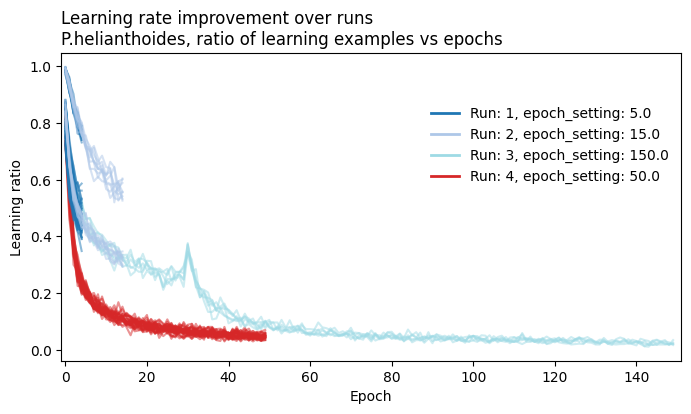

In [88]:
fig, ax = plt.subplots(1,1,figsize=(8,4))

cmap = plt.get_cmap('tab20')
norm = plt.Normalize(vmin=min(epoch_settings), vmax=max(epoch_settings))

pbar = tqdm(total=df.shape[0], desc='Plotting')
for i, row  in df.iterrows():
    path_model = row['path_model']
    if 'Pycnopodia_helianthoides' not in path_model:
        continue
    if 'Reduced' in path_model:
        continue
    epoch_setting = row['num_epochs']

    c = cmap(norm(epoch_setting))
    path_train_log = os.path.join(os.path.dirname(path_model), 'logs', 'train_learning_logs.csv')
    learning_logs = pd.read_csv(path_train_log)
    learning_epochs = sorted(learning_logs['epoch'].unique())
    num_above_zero_by_epoch = []
    num_equal_zero_by_epoch = []
    for epoch in learning_epochs:
        df_epoch = learning_logs[learning_logs['epoch'] == epoch]
        num_above_zero = len(df_epoch[df_epoch['loss'] > 0])
        num_equal_zero = len(df_epoch[df_epoch['loss'] == 0])
        num_above_zero_by_epoch.append(num_above_zero)
        num_equal_zero_by_epoch.append(num_equal_zero)
    ratio_above_zero_by_epoch = np.array(num_above_zero_by_epoch) / (np.array(num_above_zero_by_epoch) + np.array(num_equal_zero_by_epoch))

    ax.plot(learning_epochs, ratio_above_zero_by_epoch, color=c, label=f'epoch setting: {epoch_setting}', alpha=0.5)

    pbar.update(1)
pbar.close()

legend_elements = []
def get_run_key(epoch_setting):
    if epoch_setting == 5.0:
        return 1
    elif epoch_setting == 15.0:
        return 2
    elif epoch_setting == 50.0:
        return 4
    elif epoch_setting == 150.0:
        return 3

for j, epoch_setting in enumerate(sorted(epoch_settings, key = lambda x: get_run_key(x))):
  c = cmap(norm(epoch_setting))
  run = get_run_key(epoch_setting)
  legend_elements.append(Line2D([0], [0], linewidth=2,
                                label=f'Run: {run}, epoch_setting: {epoch_setting}', color=c))
ax.legend(handles=legend_elements,loc='center right', bbox_to_anchor=(1, .7), frameon=False)

ax.set_xlabel('Epoch')
ax.set_ylabel('Learning ratio')
ax.set_xlim(-1,151)

ax.set_title('Learning rate improvement over runs\nP.helianthoides, ratio of learning examples vs epochs', loc='left')

path_plot = os.path.join(evals_root_summary_stats, 'ratio_learning_examples_vs_epochs_by_epoch_setting.png')
plt.savefig(path_plot, bbox_inches='tight', dpi=300)

plt.show()
plt.close()

Plotting:   7%|▋         | 30/401 [00:01<00:17, 20.75it/s]


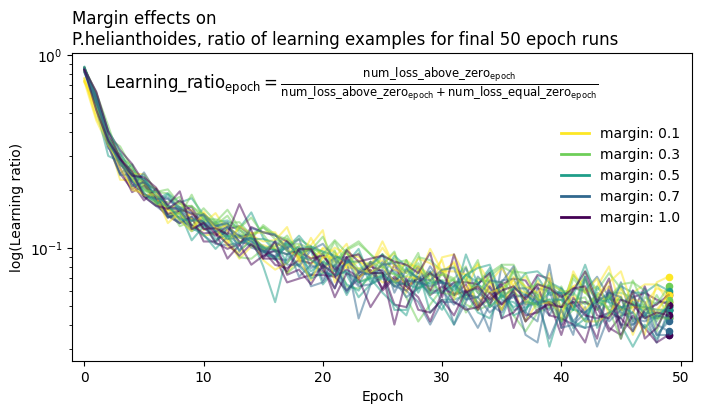

In [90]:

fig, ax = plt.subplots(1,1,figsize=(8,4))

cmap = plt.get_cmap('viridis_r')
norm = plt.Normalize(vmin=min(margin_settings), vmax=max(margin_settings))

pbar = tqdm(total=df.shape[0], desc='Plotting')
for i, row  in df.iterrows():
    path_model = row['path_model']
    if 'Pycnopodia_helianthoides' not in path_model:
        continue
    if 'Reduced' in path_model:
        continue
    epoch_setting = row['num_epochs']
    if epoch_setting != 50.0:
        continue

    margin = row['margin']
    c = cmap(norm(margin))
    path_train_log = os.path.join(os.path.dirname(path_model), 'logs', 'train_learning_logs.csv')
    learning_logs = pd.read_csv(path_train_log)
    learning_epochs = sorted(learning_logs['epoch'].unique())
    num_above_zero_by_epoch = []
    num_equal_zero_by_epoch = []
    for epoch in learning_epochs:
        df_epoch = learning_logs[learning_logs['epoch'] == epoch]
        num_above_zero = len(df_epoch[df_epoch['loss'] > 0])
        num_equal_zero = len(df_epoch[df_epoch['loss'] == 0])
        num_above_zero_by_epoch.append(num_above_zero)
        num_equal_zero_by_epoch.append(num_equal_zero)
    ratio_above_zero_by_epoch = np.array(num_above_zero_by_epoch) / (np.array(num_above_zero_by_epoch) + np.array(num_equal_zero_by_epoch))

    ax.plot(learning_epochs, ratio_above_zero_by_epoch, color=c, label=f'margin: {margin}', alpha=0.5)
    ## plot the final point as a large dot
    ax.scatter(learning_epochs[-1], ratio_above_zero_by_epoch[-1], color=c, s=20)

    pbar.update(1)
pbar.close()

legend_elements = []
for j, margin in enumerate(margin_settings):
  c = cmap(norm(margin))
  legend_elements.append(Line2D([0], [0], linewidth=2,
                                label=f'margin: {margin}', color=c))
ax.legend(handles=legend_elements,loc='center right', bbox_to_anchor=(1, .6), frameon=False)

ax.set_xlabel('Epoch')
ax.set_ylabel('log(Learning ratio)')
ax.set_xlim(-1,51)

ax.set_yscale('log')

ax.set_title('Margin effects on\nP.helianthoides, ratio of learning examples for final 50 epoch runs', loc='left')

# Define the equation text
equation_text = r"$\mathrm{Learning\_ratio}_{\mathrm{epoch}} = \frac{\mathrm{num\_loss\_above\_zero}_{\mathrm{epoch}}}{\mathrm{num\_loss\_above\_zero}_{\mathrm{epoch}} + \mathrm{num\_loss\_equal\_zero}_{\mathrm{epoch}}}$"

# Add the equation text to the plot in the top center
ax.text(0.45, 0.9, equation_text, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=12)

path_plot = os.path.join(evals_root_summary_stats, 'ratio_learning_examples_vs_epochs_by_margin_setting.png')
plt.savefig(path_plot, bbox_inches='tight', dpi=300)

plt.show()
plt.close()

In [10]:
summary_dict = {'source_dataset':[],
                'margin':[],
                'num_epochs':[],
                'unfreezing_settings':[],
                'batch_size':[],
                'embedding_dim':[],
                'n_layers':[],
                'mAP@1':[],
                'mAP@5':[],
                'mAP@10':[],
                'mAP@15':[],
                'mAP@20':[]}

total = len(source_datasets) * len(margin_settings) * len(epoch_settings) * len(unq_unfreezing_settings) * len(batchsize_settings) * len(embeddingdim_settings) * len(layer_settings)
pbar = tqdm(total=total, desc='Processing')

for src_dataset in source_datasets:
  for margin in margin_settings:
    for num_epochs in epoch_settings:
      for unfreezing_settings in unq_unfreezing_settings:
        for batch_size in batchsize_settings:
          for embedding_dim in embeddingdim_settings:
            for n_layers in layer_settings:
                tmp = df[(df['source_dataset'] == src_dataset) &
                         (df['margin'] == margin) &
                         (df['num_epochs'] == num_epochs) &
                         (df['unfreezing_settings'] == unfreezing_settings) &
                         (df['batch_size'] == batch_size) &
                         (df['embedding_dim'] == embedding_dim) &
                         (df['n_layers'] == n_layers)]
                if tmp.shape[0] > 0:
                    mAP_dict = tmp['mAP_score'].values[0]
                    x, y = convert_mAP_dict_into_arr(mAP_dict)
                    summary_dict['source_dataset'].append(src_dataset)
                    summary_dict['margin'].append(margin)
                    summary_dict['num_epochs'].append(num_epochs)
                    summary_dict['unfreezing_settings'].append(unfreezing_settings)
                    summary_dict['batch_size'].append(batch_size)
                    summary_dict['embedding_dim'].append(embedding_dim)
                    summary_dict['n_layers'].append(n_layers)
                    for X,Y in zip(x,y):
                        summary_dict[f'mAP@{X}'].append(Y)
                pbar.update(1)
pbar.close()

Processing: 100%|██████████| 11520/11520 [00:12<00:00, 934.91it/s]


In [11]:
summary = pd.DataFrame(summary_dict)
summary.head()

,source_dataset,margin,num_epochs,unfreezing_settings,batch_size,embedding_dim,n_layers,mAP@1,mAP@5,mAP@10,mAP@15,mAP@20
0,ANAU,0.3,5.0,No unfreezing,8.0,64.0,1.0,0.800000,0.941860,0.972093,0.981395,0.983721
1,ANAU,0.3,5.0,No unfreezing,8.0,64.0,2.0,0.760465,0.897674,0.941860,0.958140,0.969767
2,ANAU,0.3,5.0,No unfreezing,8.0,64.0,3.0,0.718605,0.881395,0.934884,0.951163,0.972093
3,ANAU,0.3,5.0,No unfreezing,8.0,128.0,1.0,0.860465,0.958140,0.976744,0.986047,0.990698
4,ANAU,0.3,5.0,No unfreezing,8.0,128.0,2.0,0.800000,0.930233,0.955814,0.976744,0.979070


In [12]:
summary.shape

(128, 12)

In [13]:
summary_stats = summary.groupby(['source_dataset',
                                 'margin',
                                 'num_epochs',
                                'unfreezing_settings',
                                 'batch_size',
                                 'embedding_dim',
                                 'n_layers']).agg(['mean']).sort_values(by=('mAP@1', 'mean'), ascending=False).round(4)
summary_stats.shape

(128, 5)

In [14]:
summary_stats

mAP@1  \
                                                                                                         mean   
source_dataset          margin num_epochs unfreezing_settings       batch_size embedding_dim n_layers           
Reduced P.helianthoides 0.1    50.0       128L@epoch1               8.0        256.0         3.0       0.9378   
P.helianthoides         0.1    50.0       128L@epoch1               8.0        256.0         3.0       0.9369   
Reduced P.helianthoides 0.3    5.0        No unfreezing             8.0        256.0         1.0       0.9355   
                               50.0       128L@epoch1               8.0        256.0         3.0       0.9347   
P.helianthoides         0.3    150.0      all@epoch30               8.0        256.0         3.0       0.9335   
...                                                                                                       ...   
ANAU                    0.3    150.0      128L@epoch20, all@epoch50 8.0        256.0         3.0       0.7767   
Unmasked ANAU           0.3    5.0        No unfreezing             8.0        64.0          2.0       0.7718   
ANAU                    0.3    5.0        No unfreezing             8.0        64.0          2.0       0.7605   
                                                                                             3.0       0.7186   
Unmasked ANAU           0.3    5.0        No unfreezing             8.0        64.0          3.0       0.7129   

                                                                                                        mAP@5  \
                                                                                                         mean   
source_dataset          margin num_epochs unfreezing_settings       batch_size embedding_dim n_layers           
Reduced P.helianthoides 0.1    50.0       128L@epoch1               8.0        256.0         3.0       0.9712   
P.helianthoides         0.1    50.0       128L@epoch1               8.0        256.0         3.0       0.9636   
Reduced P.helianthoides 0.3    5.0        No unfreezing             8.0        256.0         1.0       0.9666   
                               50.0       128L@epoch1               8.0        256.0         3.0       0.9627   
P.helianthoides         0.3    150.0      all@epoch30               8.0        256.0         3.0       0.9588   
...                                                                                                       ...   
ANAU                    0.3    150.0      128L@epoch20, all@epoch50 8.0        256.0         3.0       0.9116   
Unmasked ANAU           0.3    5.0        No unfreezing             8.0        64.0          2.0       0.9224   
ANAU                    0.3    5.0        No unfreezing             8.0        64.0          2.0       0.8977   
                                                                                             3.0       0.8814   
Unmasked ANAU           0.3    5.0        No unfreezing             8.0        64.0          3.0       0.9059   

                                                                                                       mAP@10  \
                                                                                                         mean   
source_dataset          margin num_epochs unfreezing_settings       batch_size embedding_dim n_layers           
Reduced P.helianthoides 0.1    50.0       128L@epoch1               8.0        256.0         3.0       0.9790   
P.helianthoides         0.1    50.0       128L@epoch1               8.0        256.0         3.0       0.9705   
Reduced P.helianthoides 0.3    5.0        No unfreezing             8.0        256.0         1.0       0.9774   
                               50.0       128L@epoch1               8.0        256.0         3.0       0.9751   
P.helianthoides         0.3    150.0      all@epoch30               8.0        256.0         3.0       0.9691   
...                               

Plotting: 100%|██████████| 128/128 [00:00<00:00, 707.18it/s]


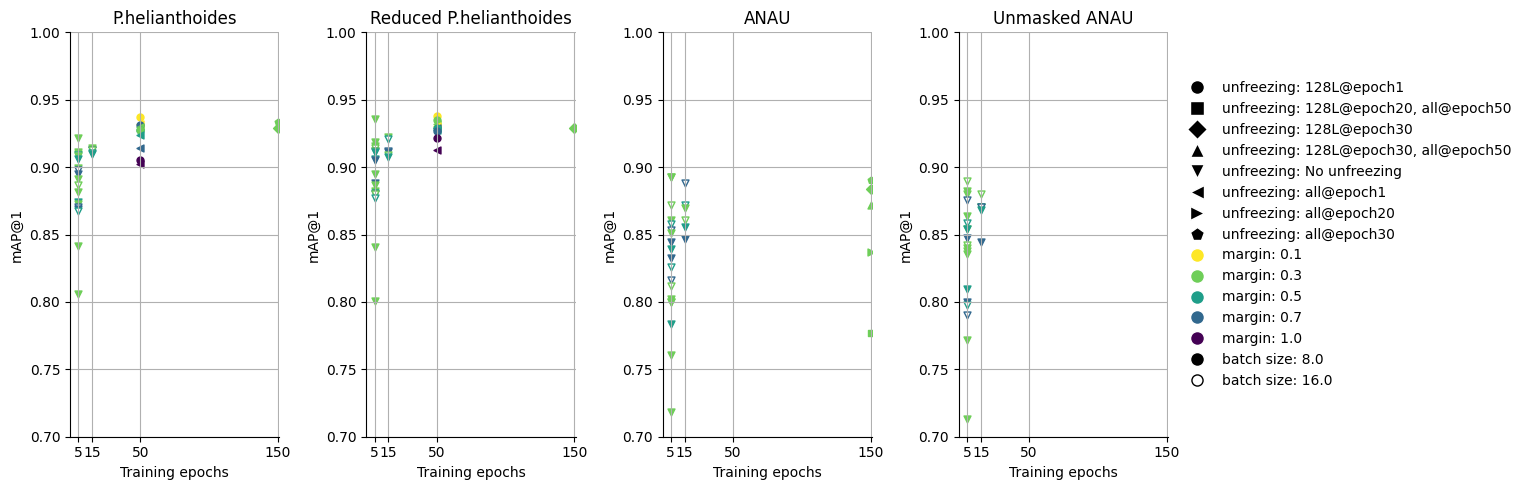

In [15]:
ncols = len(source_datasets)

fig, axs = plt.subplots(1, ncols, figsize=(ncols*3, 5))

cmap = plt.get_cmap('viridis_r')
norm = plt.Normalize(vmin=min(margin_settings), vmax=max(margin_settings))

# Define a list of unique markers
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', '+', 'x', '|', '_', '1', '2', '3', '4']

# Ensure we have enough markers
if len(unq_unfreezing_settings) > len(markers):
    raise ValueError("Not enough unique markers for the number of settings.")

batchsize_settings_fill_dict = {8.0:True, 16.0:False}

# Create the dictionary
unq_unfreezing_marker_dict = {setting: markers[i] for i, setting in enumerate(unq_unfreezing_settings)}

## dataset:i key
dataset_i_key = {'ANAU': 2,
                 'P.helianthoides': 0,
                 'Reduced P.helianthoides': 1,
                 'Unmasked ANAU': 3}

for i, src_dataset in enumerate(source_datasets):
    ax = axs[dataset_i_key[src_dataset]]
    ax.set_title(src_dataset)
    ax.set_xlabel('Training epochs')
    ax.set_ylabel('mAP@1')
    ax.set_ylim(0.7, 1)
    ax.set_xlim(-1, 151)
    xticks = epoch_settings
    ax.set_xticks(xticks)

    ## turn off top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_yticks(np.arange(0.7, 1.01, 0.05))
    ax.grid(True)

pbar = tqdm(total = summary_stats.shape[0], desc='Plotting')
for row, mAPs in summary_stats.iterrows():

    src_dataset = row[0]
    margin = row[1]
    c = cmap(norm(margin))

    num_epochs = row[2]
    unfreezing_settings = row[3]
    marker = unq_unfreezing_marker_dict[unfreezing_settings]

    batch_size = row[4]
    fill = batchsize_settings_fill_dict[batch_size]
    embedding_dim = row[5]
    n_layers = row[6]

    dataset_i = dataset_i_key[src_dataset]

    ax = axs[dataset_i]

    mAP1 = mAPs.values[0]

    if fill:
        ax.scatter(num_epochs, mAP1, color=c, marker=marker, s=25)
    else:
        ax.scatter(num_epochs, mAP1, color='white', marker=marker, s=25, edgecolors=c)

    pbar.update(1)
pbar.close()

fig.tight_layout()

legend_elements = []
for i, unfreezing_setting in enumerate(unq_unfreezing_settings):
    marker = unq_unfreezing_marker_dict[unfreezing_setting]
    legend_elements.append(Line2D([0], [0], marker=marker, color='w', label=f'unfreezing: {unfreezing_setting}', markerfacecolor='black', markersize=10))

for j, margin in enumerate(margin_settings):
    c = cmap(norm(margin))
    legend_elements.append(Line2D([0], [0], marker='o', color='w', label=f'margin: {margin}', markerfacecolor=c, markersize=10))

for item, value in batchsize_settings_fill_dict.items():
    if value:  # Filled black circle for True
        legend_elements.append(Line2D([0], [0], marker='o', color='w', label=f'batch size: {item}', markerfacecolor='black', markersize=10))
    else:  # Circle with only the edges colored for False
        legend_elements.append(Line2D([0], [0], marker='o', color='w', label=f'batch size: {item}', markerfacecolor='none', markersize=8, markeredgecolor='black'))

ax = axs[3]
ax.legend(handles=legend_elements,loc='center right', bbox_to_anchor=(2.7, .5), frameon=False)

path_plot = os.path.join(evals_root_summary_stats, 'mAP@1_vs_epochs.png')
plt.savefig(path_plot, bbox_inches='tight', dpi=300)

plt.show()
plt.close()

In [16]:
best_models = []
for epoch in epoch_settings:
    tmp = summary_stats[summary_stats.index.get_level_values('num_epochs') == epoch]
    for src_dataset in ['P.helianthoides', 'Reduced P.helianthoides', 'ANAU', 'Unmasked ANAU']:
        tmp2 = tmp[tmp.index.get_level_values('source_dataset') == src_dataset]
        if tmp2.shape[0] > 0:
            ## get the best mAP@1 row
            tmp2 = tmp2.sort_values(by=('mAP@1', 'mean'), ascending=False).head(1)
            best_models.append(tmp2)
best_models = pd.concat(best_models)
best_models




,,,,,,,mAP@1,mAP@5,mAP@10,mAP@15,mAP@20
,,,,,,,mean,mean,mean,mean,mean
source_dataset,margin,num_epochs,unfreezing_settings,batch_size,embedding_dim,n_layers,,,,,
P.helianthoides,0.3,5.0,No unfreezing,8.0,256.0,1.0,0.9218,0.9492,0.9630,0.9712,0.9753
Reduced P.helianthoides,0.3,5.0,No unfreezing,8.0,256.0,1.0,0.9355,0.9666,0.9774,0.9806,0.9837
ANAU,0.3,5.0,No unfreezing,8.0,256.0,1.0,0.8930,0.9721,0.9837,0.9860,0.9907
Unmasked ANAU,0.3,5.0,No unfreezing,16.0,256.0,3.0,0.8894,0.9600,0.9835,0.9859,0.9882
P.helianthoides,0.3,15.0,No unfreezing,8.0,256.0,3.0,0.9143,0.9527,0.9684,0.9733,0.9767
Reduced P.helianthoides,0.3,15.0,No unfreezing,8.0,256.0,3.0,0.9222,0.9666,0.9774,0.9821,0.9852
ANAU,0.7,15.0,No unfreezing,16.0,256.0,3.0,0.8884,0.9558,0.9744,0.9837,0.9860
Unmasked ANAU,0.3,15.0,No unfreezing,16.0,256.0,3.0,0.8800,0.9576,0.9788,0.9906,0.9976


In [17]:
best_models = []
for src_dataset in ['P.helianthoides', 'Reduced P.helianthoides', 'ANAU', 'Unmasked ANAU']:
    tmp = summary_stats[summary_stats.index.get_level_values('source_dataset') == src_dataset]
    tmp = tmp.sort_values(by=('mAP@1', 'mean'), ascending=False).head(1)
    best_models.append(tmp)
best_models = pd.concat(best_models)
best_models

,,,,,,,mAP@1,mAP@5,mAP@10,mAP@15,mAP@20
,,,,,,,mean,mean,mean,mean,mean
source_dataset,margin,num_epochs,unfreezing_settings,batch_size,embedding_dim,n_layers,,,,,
P.helianthoides,0.1,50.0,128L@epoch1,8.0,256.0,3.0,0.9369,0.9636,0.9705,0.9760,0.9801
Reduced P.helianthoides,0.1,50.0,128L@epoch1,8.0,256.0,3.0,0.9378,0.9712,0.9790,0.9837,0.9852
ANAU,0.3,5.0,No unfreezing,8.0,256.0,1.0,0.8930,0.9721,0.9837,0.9860,0.9907
Unmasked ANAU,0.3,5.0,No unfreezing,16.0,256.0,3.0,0.8894,0.9600,0.9835,0.9859,0.9882
